## 不管特征工程，直接原始数据拿来建模，稍微把目标函数，缺失值填充一下，做下简单的标准化

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#导入数据
car_df=pd.read_csv(r'E:\Machine Learning\used_car_train_20200313\used_car_train_20200313.csv',sep=' ')
#找出缺失值
car_df.isnull().sum().sort_values()

SaleID                  0
v_12                    0
v_11                    0
v_10                    0
v_9                     0
v_8                     0
v_7                     0
v_6                     0
v_5                     0
v_4                     0
v_3                     0
v_2                     0
v_1                     0
v_0                     0
v_13                    0
price                   0
offerType               0
seller                  0
regionCode              0
notRepairedDamage       0
kilometer               0
power                   0
brand                   0
regDate                 0
name                    0
creatDate               0
v_14                    0
model                   1
bodyType             4506
gearbox              5981
fuelType             8680
dtype: int64

In [11]:
#树模型可以处理缺失值，这里不打算处理这些空值，但需要对一些同一化的值进行处理
#但需要对不符合数据类型的属性进行修改
car_df['notRepairedDamage'].replace('-', np.nan, inplace=True)
#选出特征列
#categorical_features = car_df.select_dtypes(include=[np.object]).columns
#plt.hist(car_df[categorical_features],figsize=(15,25))
#plt.show()

In [4]:
#发现 以下列数据倾斜严重，删除，需要加inplace=True才能在原数据中删掉列
drop_list=['SaleID','name','offerType','seller']
car_df.drop(drop_list,axis=1,inplace=True)
car_df.shape

(150000, 27)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


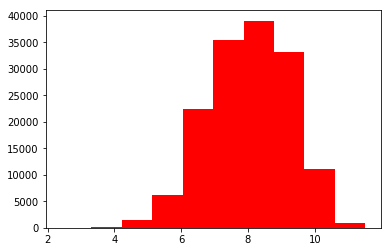

In [12]:
#提取标签,这里使用切片的方法
y_target=car_df.ix[:,'price']
train_x=car_df.ix[:,car_df.columns!='price']
#价格取对数
train_y=np.log(y_target)
plt.hist(train_y, orientation = 'vertical',histtype = 'bar', color ='red')
plt.show()

In [17]:
#利用lightgbm 进行数据训练
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [18]:
#数据分组
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train_x.values,train_y.values,test_size=0.1,random_state=18)
#create dataset for lightgbm
#传进来的是dataframe或者series
lgb_train = lgb.Dataset(x_train,y_train)
lgb_eval = lgb.Dataset(x_test,y_test,reference=lgb_train)
#specify your configureations as a dict 训练参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
        }
print('Starting training...')

#train 开始训练
gbm = lgb.train(params,lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
print('Save model ...')
#保存模型为txt,这步没看懂
gbm.save_model('model.txt')
#用最好的参数版本进行预测 
print('Start predict')
y_pred = gbm.predict(x_test,num_iteration=gbm.best_iteration)
#eva  均方误差开方做为loss函数
print('The rmse of prediction is:',mean_absolute_error(np.exp(y_test),np.exp(y_pred))**0.5)


Starting training...
[1]	valid_0's l2: 1.34998	valid_0's auc: 1
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 1.23383	valid_0's auc: 1
[3]	valid_0's l2: 1.12696	valid_0's auc: 1
[4]	valid_0's l2: 1.02932	valid_0's auc: 1
[5]	valid_0's l2: 0.940999	valid_0's auc: 1
[6]	valid_0's l2: 0.86114	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's l2: 1.34998	valid_0's auc: 1
Save model ...
Start predict
The rmse of prediction is: 65.87641897700892


#看起来效果很不错，实际看下预测效果

In [20]:
testA=pd.read_csv(r'E:\Machine Learning\used_car_testA_20200313\used_car_testA_20200313.csv',sep=' ')
testA['notRepairedDamage'].replace('-', np.nan, inplace=True)
drop_list=['SaleID','name','offerType','seller']
testA.drop(drop_list,axis=1,inplace=True)
testA.shape

(50000, 26)

In [22]:
testA_pred = gbm.predict(testA.values,num_iteration=gbm.best_iteration)
test_A=pd.read_csv(r'E:\Machine Learning\used_car_sample_submit.csv')
test_A['price_pred']=np.exp(testA_pred)
test_A.head()

,SaleID,price,price_pred
0,150000,0,3463.036130
1,150001,0,2752.086675
2,150002,0,3218.942344
3,150003,0,3288.416992
4,150004,0,2829.622215


In [24]:
#输出看一下统计
test_A.describe()

,SaleID,price,price_pred
count,50000.000000,50000.0,50000.000000
mean,174999.500000,0.0,3087.114796
std,14433.901067,0.0,178.357039
min,150000.000000,0.0,2548.297390
25%,162499.750000,0.0,2935.176943
50%,174999.500000,0.0,3095.490306
75%,187499.250000,0.0,3218.942344
max,199999.000000,0.0,3463.036130


In [26]:
test_A.to_csv(r'E:\Machine Learning\used_car_ubmit.csv',index=False)
print('写入文件完成')

写入文件完成


提交结果后，误差为score:4347.2250，太大了

好吧，测试集与训练的划分，结果很不可靠，应该需要十折评价了

#老老实实走特征工程这条路
* 首先进行EAD,哭了呀

In [27]:
import seaborn as sns
import missingno as msno
import scipy.stats as st

In [33]:
#载入数据
path='E:\Machine Learning'
Train_data=pd.read_csv(r'E:\Machine Learning\used_car_train_20200313.csv',sep=' ')
Test_data=pd.read_csv(r'E:\Machine Learning\used_car_testA_20200313.csv',sep=' ')

In [36]:
Train_data.head().append(Train_data.tail())#append可以用

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
149995,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014
149999,149999,177672,19990204,19.0,28,6.0,0.0,1.0,193,12.5,...,0.284475,0.000000,0.040072,0.062543,0.025819,1.978453,-3.179913,0.031724,-1.483350,-0.342674


In [37]:
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [38]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

In [40]:
Train_data.isnull().sum()
#检查空值，降序输出
Test_data.isnull().sum().sort_values(ascending=False)

fuelType             2893
gearbox              1910
bodyType             1413
v_14                    0
v_13                    0
name                    0
regDate                 0
model                   0
brand                   0
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
SaleID                  0
dtype: int64

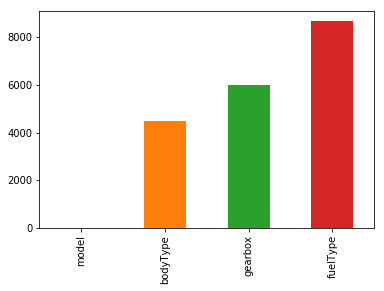

In [41]:
#可视化
missing=Train_data.isnull().sum()
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()#seriers.plot.bar()

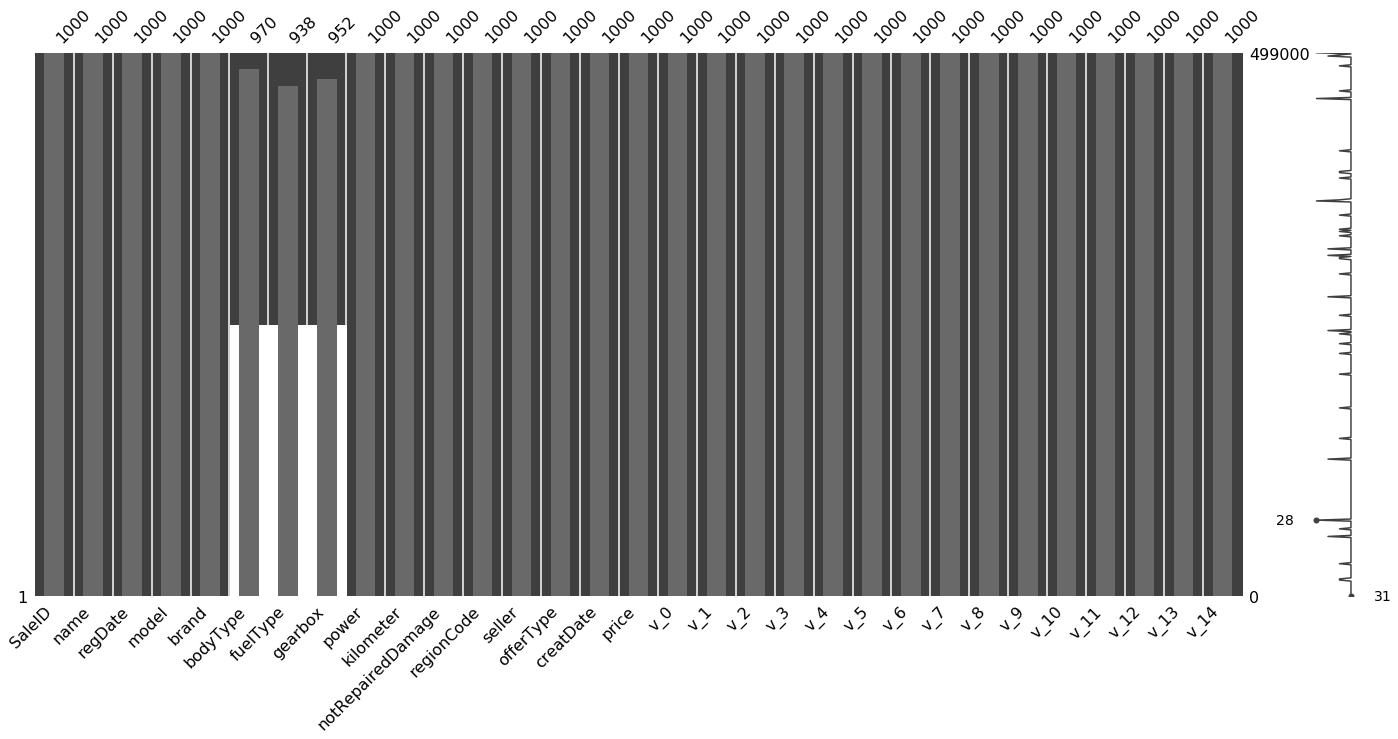

In [42]:
#可视化缺省值

msno.bar(Train_data.sample(1000))

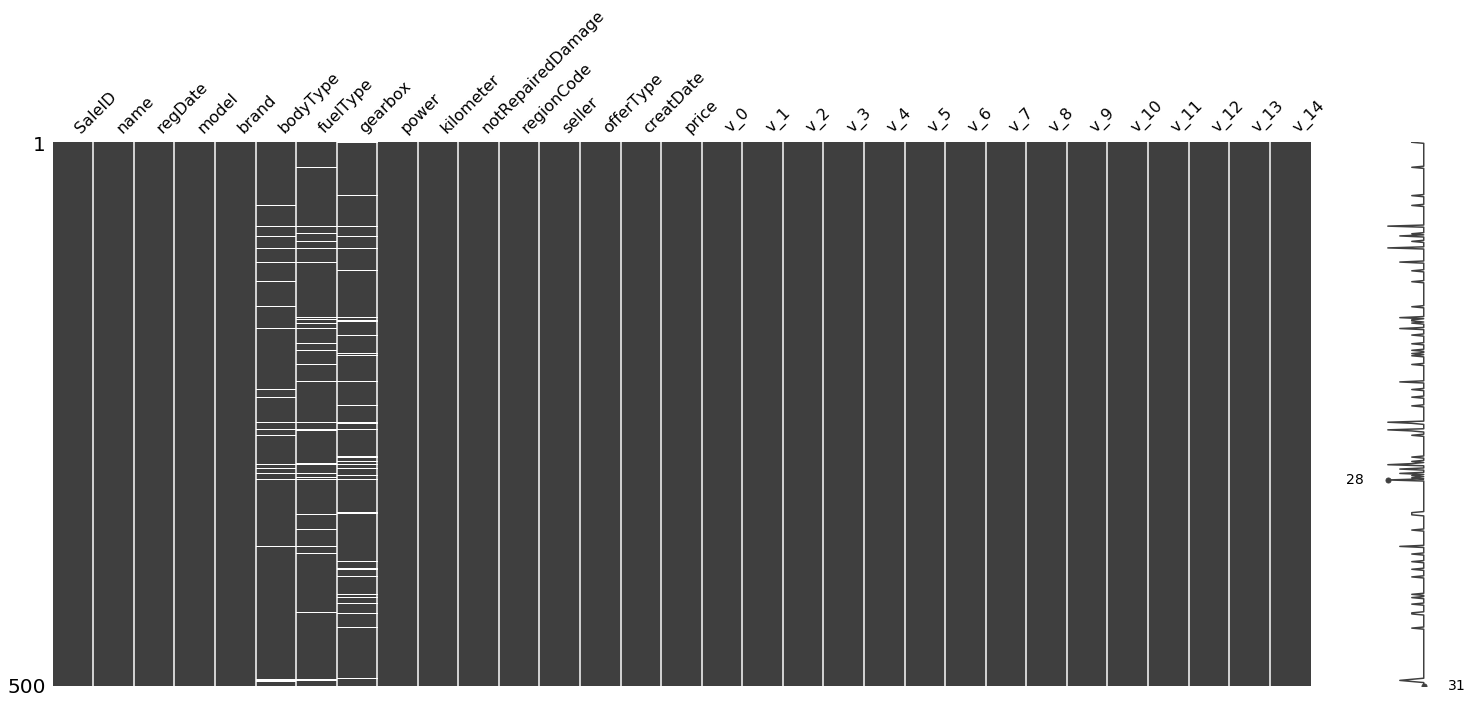

In [43]:
msno.matrix(Train_data.sample(500))

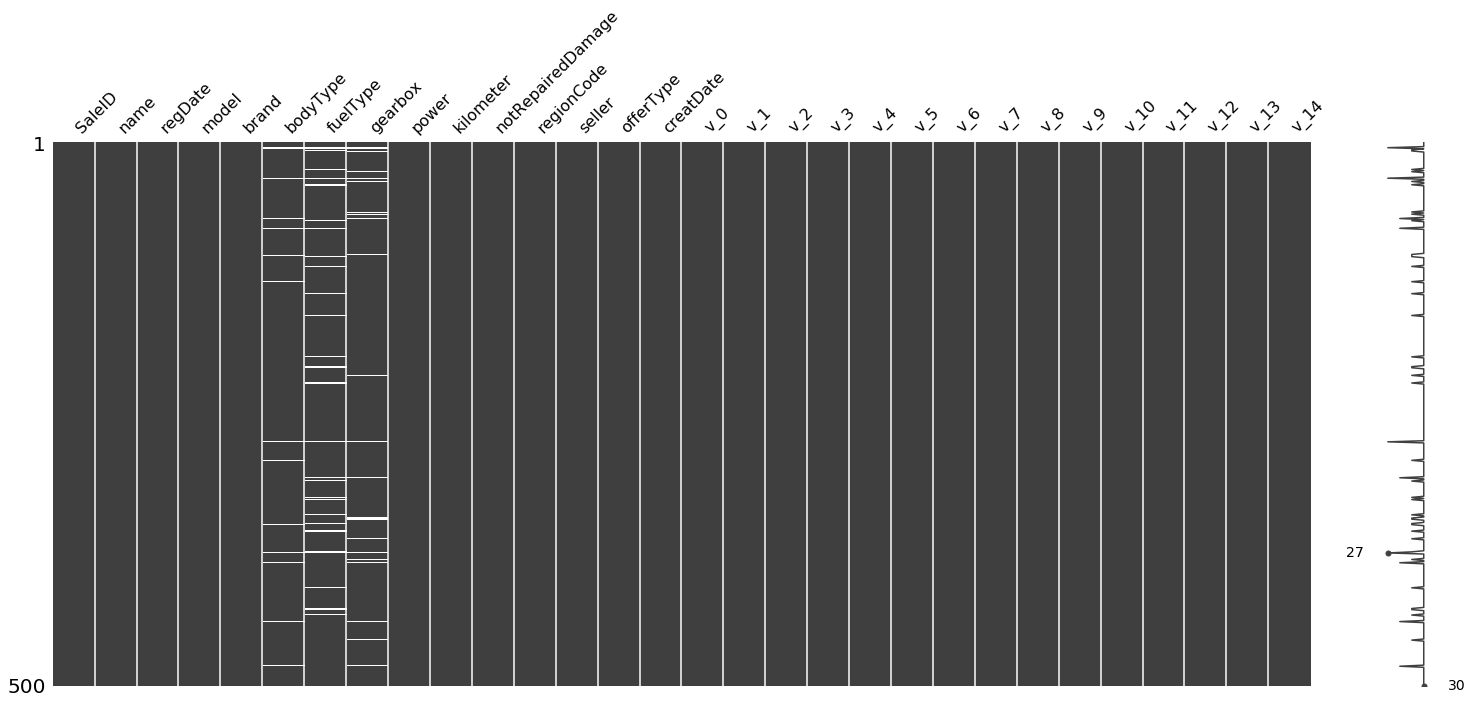

In [44]:
msno.matrix(Test_data.sample(500))

In [45]:
#将object数据值进行显示
Train_data['notRepairedDamage'].value_counts()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [47]:
#异常值做缺省值代换
Train_data['notRepairedDamage'].replace('-',np.nan,inplace=True)
Train_data['notRepairedDamage'].value_counts()

0.0    111361
1.0     14315
Name: notRepairedDamage, dtype: int64

In [48]:
#异常值，通常为严重倾斜的数据，需要删除掉
Train_data['seller'].value_counts()

0    149999
1         1
Name: seller, dtype: int64

In [49]:
Train_data['offerType'].value_counts()

0    150000
Name: offerType, dtype: int64

In [50]:
del Train_data['seller']
del Train_data['offerType']
del Test_data['seller']
del Test_data['offerType']

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


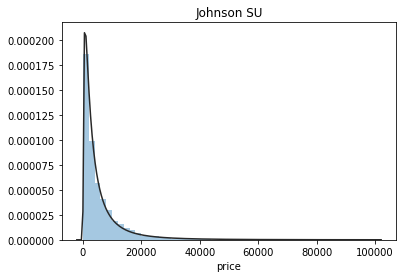

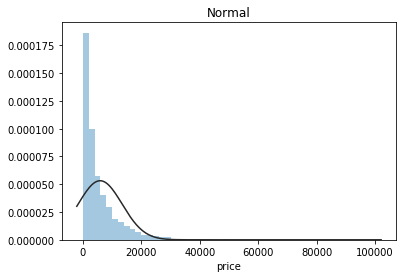

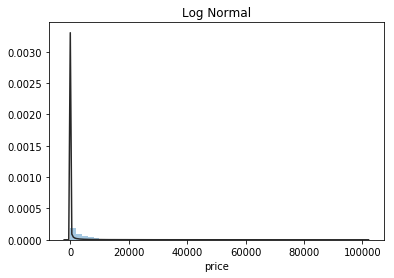

In [51]:
#基本数据处理完，需要查看数据分布
y = Train_data['price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Skewness: 3.346487
Kurtosis: 18.995183


(SaleID               6.017846e-17
 name                 5.576058e-01
 regDate              2.849508e-02
 model                1.484388e+00
 brand                1.150760e+00
 bodyType             9.915299e-01
 fuelType             1.595486e+00
 gearbox              1.317514e+00
 power                6.586318e+01
 kilometer           -1.525921e+00
 notRepairedDamage    2.430640e+00
 regionCode           6.888812e-01
 creatDate           -7.901331e+01
 price                3.346487e+00
 v_0                 -1.316712e+00
 v_1                  3.594543e-01
 v_2                  4.842556e+00
 v_3                  1.062920e-01
 v_4                  3.679890e-01
 v_5                 -4.737094e+00
 v_6                  3.680730e-01
 v_7                  5.130233e+00
 v_8                  2.046133e-01
 v_9                  4.195007e-01
 v_10                 2.522046e-02
 v_11                 3.029146e+00
 v_12                 3.653576e-01
 v_13                 2.679152e-01
 v_14               

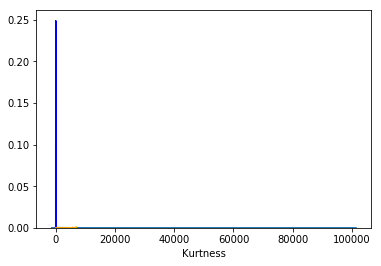

In [52]:
sns.distplot(Train_data['price']);
print("Skewness: %f" % Train_data['price'].skew())
print("Kurtosis: %f" % Train_data['price'].kurt())
sns.distplot(Train_data.skew(),color='blue',axlabel ='Skewness')
sns.distplot(Train_data.kurt(),color='orange',axlabel ='Kurtness')
Train_data.skew(), Train_data.kurt()

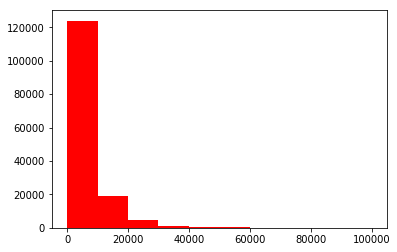

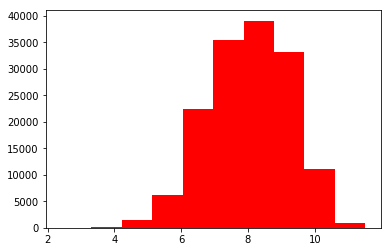

In [53]:
plt.hist(Train_data['price'], orientation = 'vertical',histtype = 'bar', color ='red')
plt.show()
plt.hist(np.log(Train_data['price']), orientation = 'vertical',histtype = 'bar', color ='red')
plt.show()

以上步骤，先对数据集的缺失值，倾斜数据进行处理，然后对目标值进行观测
并确定处理方法

In [54]:
#数值特征
numeric_features = Train_data.select_dtypes(include=[np.number])
numeric_features.columns


Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'creatDate', 'price',
       'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9',
       'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')

In [55]:
# 类型特征
categorical_features = Train_data.select_dtypes(include=[np.object])
categorical_features.columns

Index(['notRepairedDamage'], dtype='object')

In [57]:
#总览
print(numeric_features)

        SaleID    name   regDate  model  brand  bodyType  fuelType  gearbox  \
0            0     736  20040402   30.0      6       1.0       0.0      0.0   
1            1    2262  20030301   40.0      1       2.0       0.0      0.0   
2            2   14874  20040403  115.0     15       1.0       0.0      0.0   
3            3   71865  19960908  109.0     10       0.0       0.0      1.0   
4            4  111080  20120103  110.0      5       1.0       0.0      0.0   
5            5  137642  20090602   24.0     10       0.0       1.0      0.0   
6            6    2402  19990411   13.0      4       0.0       0.0      1.0   
7            7  165346  19990706   26.0     14       1.0       0.0      0.0   
8            8    2974  20030205   19.0      1       2.0       1.0      1.0   
9            9   82021  19980101    7.0      7       5.0       0.0      0.0   
10          10   18961  20050811   19.0      9       3.0       1.0      0.0   
11          11   74495  20080312    1.0      6      

price        1.000000
v_12         0.692823
v_8          0.685798
v_0          0.628397
power        0.219834
v_5          0.164317
v_2          0.085322
v_6          0.068970
v_1          0.060914
v_14         0.035911
v_13        -0.013993
v_7         -0.053024
v_4         -0.147085
v_9         -0.206205
v_10        -0.246175
v_11        -0.275320
kilometer   -0.440519
v_3         -0.730946
Name: price, dtype: float64 



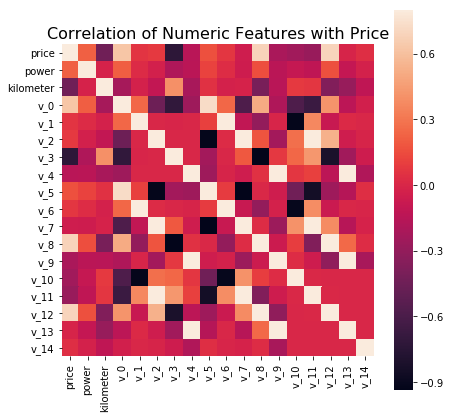

In [59]:
#相关性分析
numeric_features = ['price','power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14' ]
categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode']
price_numeric = Train_data[numeric_features]#原数据表不要动
correlation = price_numeric.corr()
#这个好，将其他特征与目标值的相关系数输出
print(correlation['price'].sort_values(ascending=False),'\n')
f, ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)
del price_numeric['price']

In [60]:
for col in numeric_features:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(Train_data[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(Train_data[col].kurt())  
         )

price           Skewness: 03.35     Kurtosis: 019.00
power           Skewness: 65.86     Kurtosis: 5733.45
kilometer       Skewness: -1.53     Kurtosis: 001.14
v_0             Skewness: -1.32     Kurtosis: 003.99
v_1             Skewness: 00.36     Kurtosis: -01.75
v_2             Skewness: 04.84     Kurtosis: 023.86
v_3             Skewness: 00.11     Kurtosis: -00.42
v_4             Skewness: 00.37     Kurtosis: -00.20
v_5             Skewness: -4.74     Kurtosis: 022.93
v_6             Skewness: 00.37     Kurtosis: -01.74
v_7             Skewness: 05.13     Kurtosis: 025.85
v_8             Skewness: 00.20     Kurtosis: -00.64
v_9             Skewness: 00.42     Kurtosis: -00.32
v_10            Skewness: 00.03     Kurtosis: -00.58
v_11            Skewness: 03.03     Kurtosis: 012.57
v_12            Skewness: 00.37     Kurtosis: 000.27
v_13            Skewness: 00.27     Kurtosis: -00.44
v_14            Skewness: -1.19     Kurtosis: 002.39


每个数字特征的分布可视化
pd.melt()：处理数据，透视表格，可将宽数据转化为长数据，以便于后续分析。形成的数据即为，键：各特征名称，值：特征对应的值
sns.FacetGrid() ：先sns.FacetGrid()画出轮廓,再map()填充内容

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


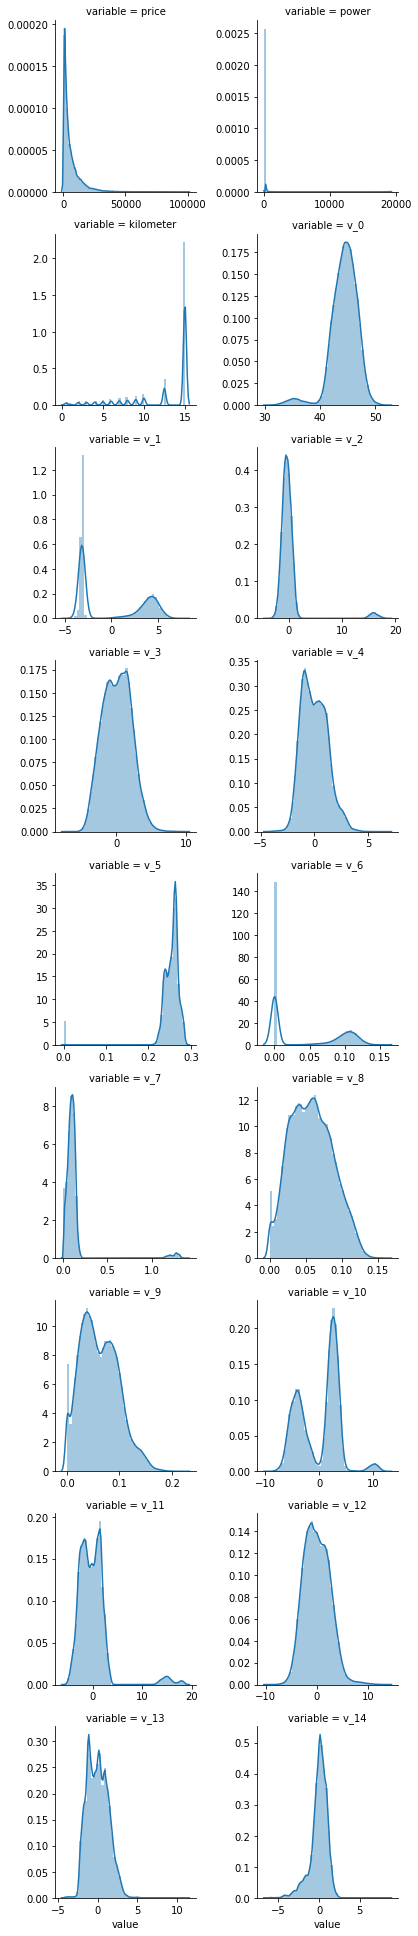

In [61]:
f = pd.melt(Train_data, value_vars=numeric_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

匿名特征分布情况
* sns.pairplot()：展示变量两两之间的关系（线性或非线性，有无较为明显的相关关系）：
对角线：各个属性的直方图，用diag_kind属性控制图类型，可选"scatter"与"reg"
非对角线：两个不同属性之间的相关图，用kind属性控制图类型，可选"scatter"与"reg"
* hue ：针对某一字段进行分类

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


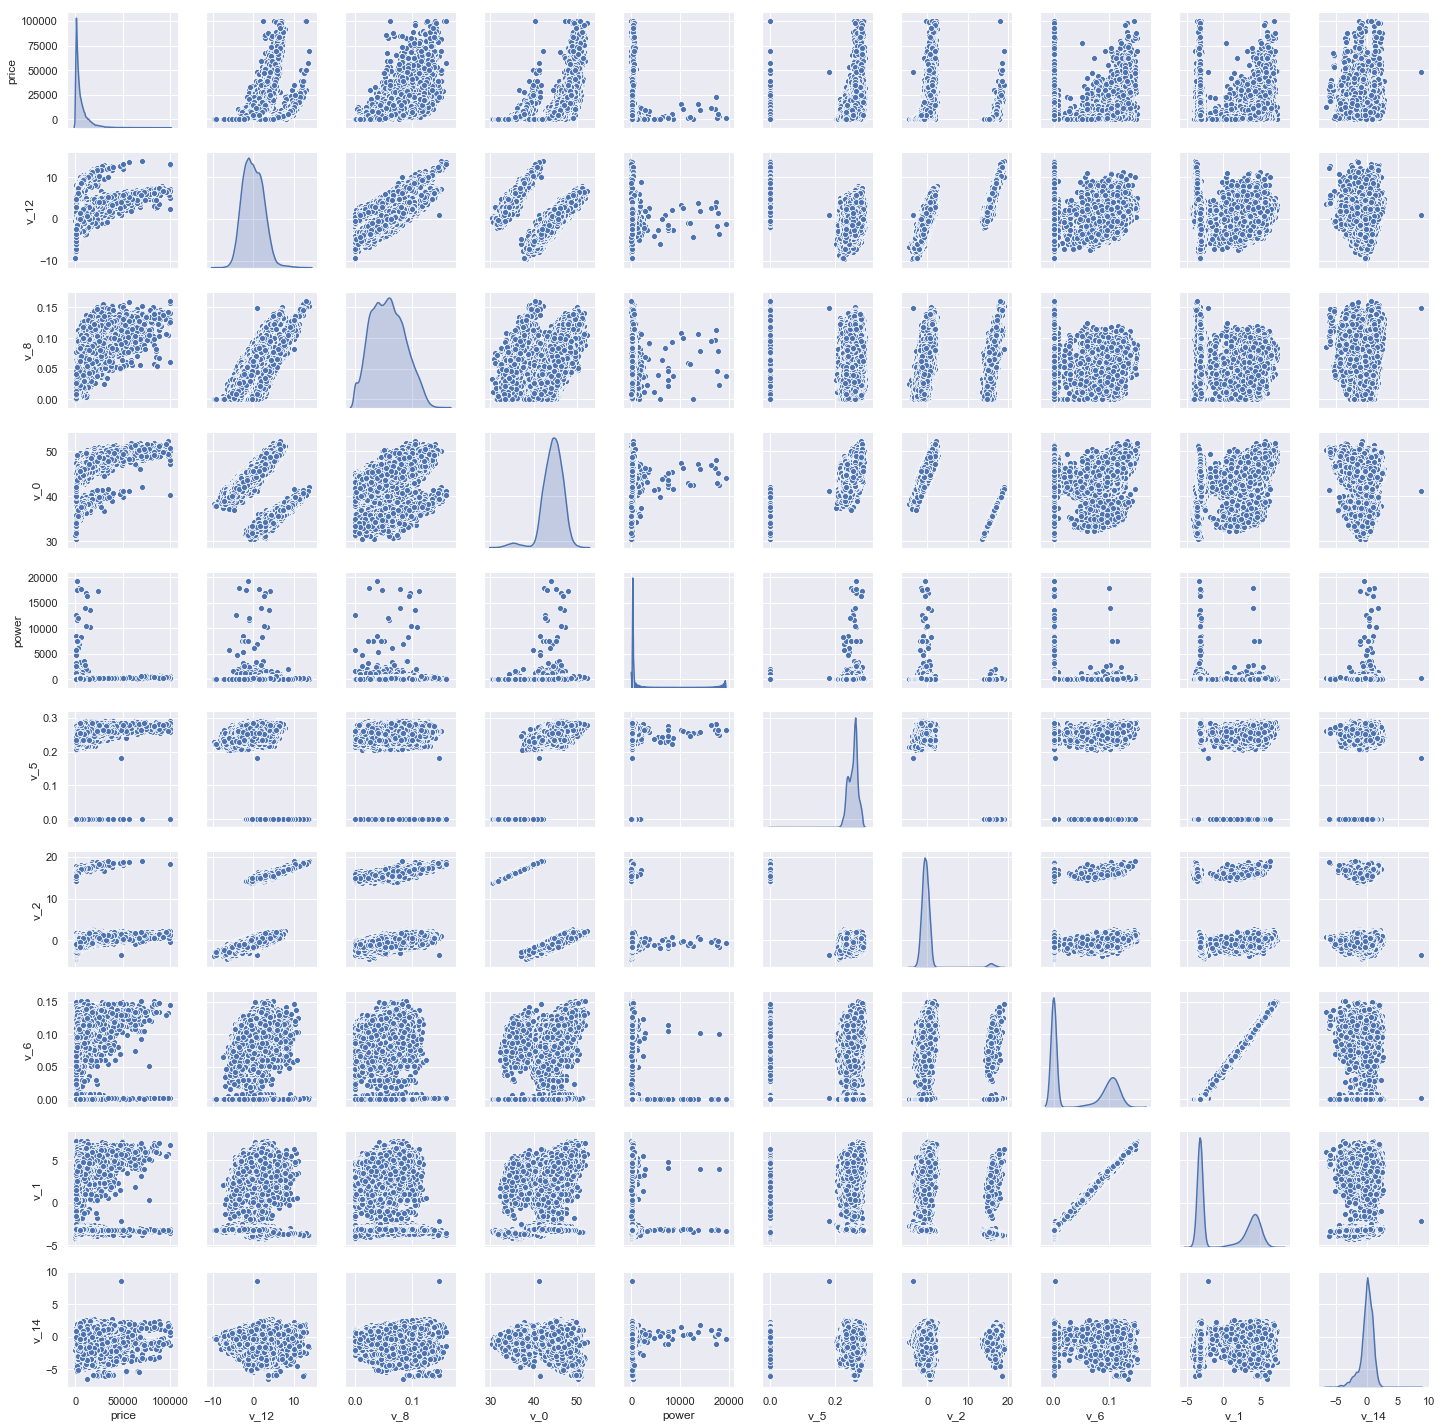

In [62]:
#将与目标数据正相关的数据取出，一起分析数据之间的关系
sns.set()
columns = ['price', 'v_12', 'v_8' , 'v_0', 'power', 'v_5',  'v_2', 'v_6', 'v_1', 'v_14']
sns.pairplot(Train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

多变量与price的回归关系

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


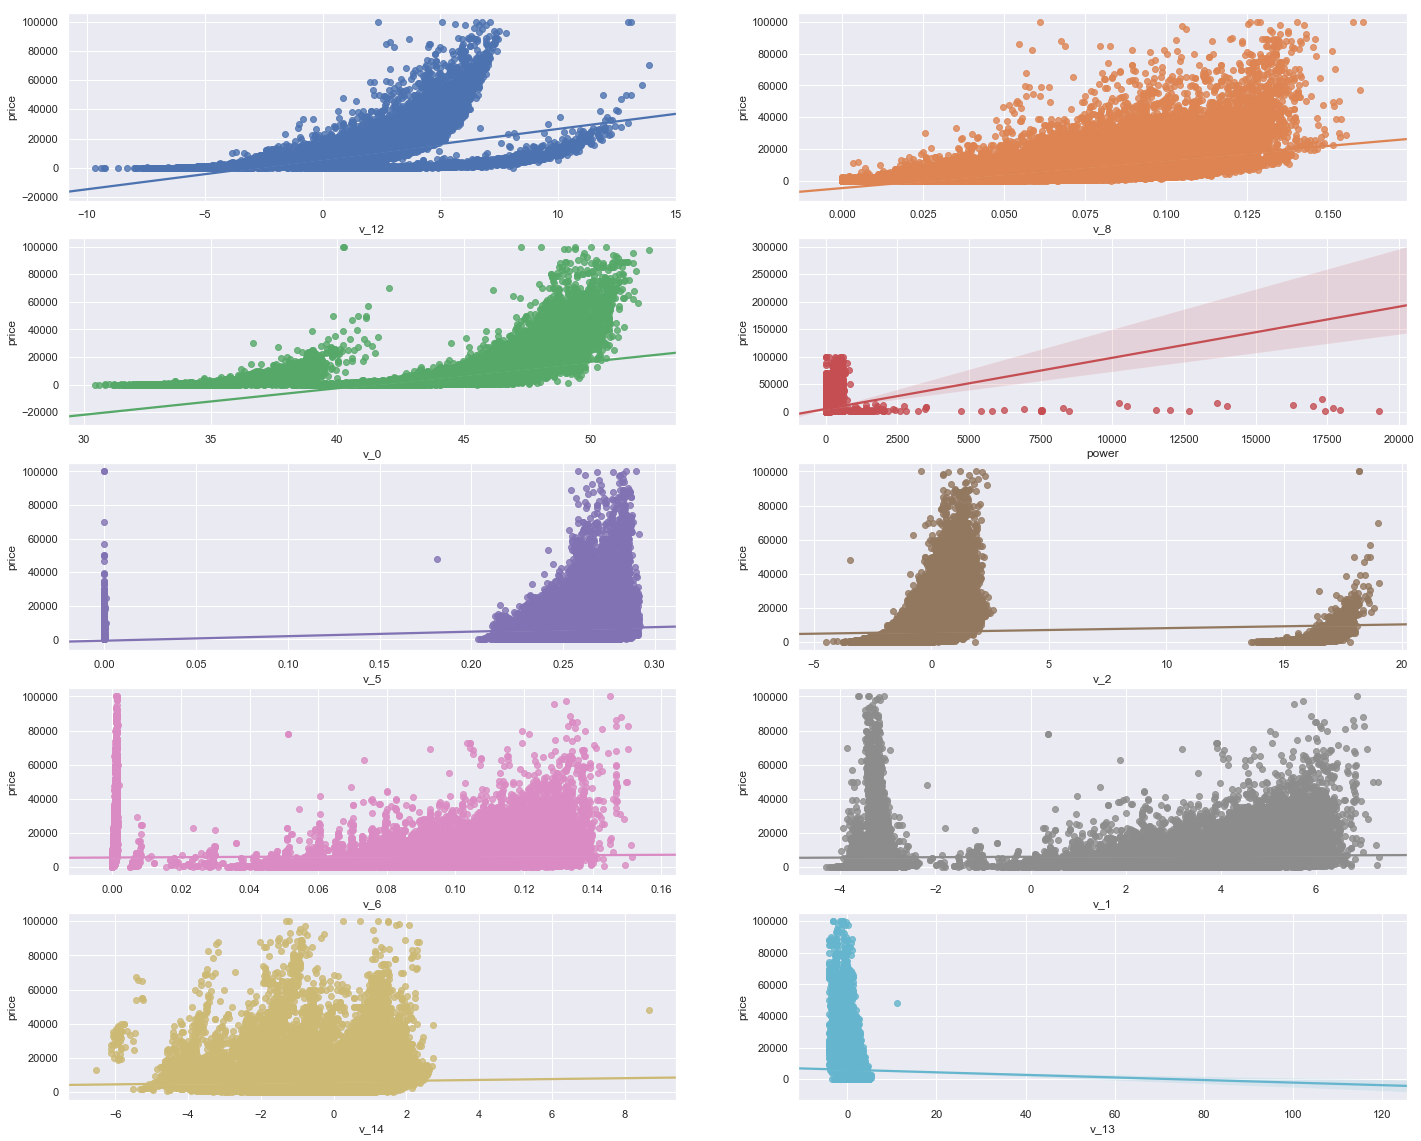

In [64]:
#分析这些变量与目标值的回归关系
Y_train=Train_data['price']
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=5, ncols=2, figsize=(24, 20))
# ['v_12', 'v_8' , 'v_0', 'power', 'v_5',  'v_2', 'v_6', 'v_1', 'v_14']
v_12_scatter_plot = pd.concat([Y_train,Train_data['v_12']],axis = 1)
sns.regplot(x='v_12',y = 'price', data = v_12_scatter_plot,scatter= True, fit_reg=True, ax=ax1)

v_8_scatter_plot = pd.concat([Y_train,Train_data['v_8']],axis = 1)
sns.regplot(x='v_8',y = 'price',data = v_8_scatter_plot,scatter= True, fit_reg=True, ax=ax2)

v_0_scatter_plot = pd.concat([Y_train,Train_data['v_0']],axis = 1)
sns.regplot(x='v_0',y = 'price',data = v_0_scatter_plot,scatter= True, fit_reg=True, ax=ax3)

power_scatter_plot = pd.concat([Y_train,Train_data['power']],axis = 1)
sns.regplot(x='power',y = 'price',data = power_scatter_plot,scatter= True, fit_reg=True, ax=ax4)

v_5_scatter_plot = pd.concat([Y_train,Train_data['v_5']],axis = 1)
sns.regplot(x='v_5',y = 'price',data = v_5_scatter_plot,scatter= True, fit_reg=True, ax=ax5)

v_2_scatter_plot = pd.concat([Y_train,Train_data['v_2']],axis = 1)
sns.regplot(x='v_2',y = 'price',data = v_2_scatter_plot,scatter= True, fit_reg=True, ax=ax6)

v_6_scatter_plot = pd.concat([Y_train,Train_data['v_6']],axis = 1)
sns.regplot(x='v_6',y = 'price',data = v_6_scatter_plot,scatter= True, fit_reg=True, ax=ax7)

v_1_scatter_plot = pd.concat([Y_train,Train_data['v_1']],axis = 1)
sns.regplot(x='v_1',y = 'price',data = v_1_scatter_plot,scatter= True, fit_reg=True, ax=ax8)

v_14_scatter_plot = pd.concat([Y_train,Train_data['v_14']],axis = 1)
sns.regplot(x='v_14',y = 'price',data = v_14_scatter_plot,scatter= True, fit_reg=True, ax=ax9)

v_13_scatter_plot = pd.concat([Y_train,Train_data['v_13']],axis = 1)
sns.regplot(x='v_13',y = 'price',data = v_13_scatter_plot,scatter= True, fit_reg=True, ax=ax10)

# 类别特征

In [65]:
#查看nunique分布
for cat_fea in categorical_features:
    print(cat_fea + '特征分布如下：')
    print('{}特征有{}个不同的值'.format(cat_fea, Train_data[cat_fea].nunique()))
    print(Train_data[cat_fea].value_counts())

name特征分布如下：
name特征有99662个不同的值
708       282
387       282
55        280
1541      263
203       233
53        221
713       217
290       197
1186      184
911       182
2044      176
1513      160
1180      158
631       157
893       153
2765      147
473       141
1139      137
1108      132
444       129
306       127
2866      123
2402      116
533       114
1479      113
422       113
4635      110
725       110
964       109
1373      104
         ... 
89083       1
95230       1
164864      1
173060      1
179207      1
181256      1
185354      1
25564       1
19417       1
189324      1
162719      1
191373      1
193422      1
136082      1
140180      1
144278      1
146327      1
148376      1
158621      1
1404        1
15319       1
46022       1
64463       1
976         1
3025        1
5074        1
7123        1
11221       1
13270       1
174485      1
Name: name, Length: 99662, dtype: int64
model特征分布如下：
model特征有248个不同的值
0.0      11762
19.0      9573
4.0       8445
1

查看箱型图
* 直观识别数据中的离群点
* 直观判断数据离散分布情况，了解数据分布状态

In [ ]:
#如果有任何缺失值，则添加missing类，并将缺失值用missing代替
for c in categorical_features:
    Train_data[c] = Train_data[c].astype('category')
    if Train_data[c].isnull().any():
        Train_data[c] = Train_data[c].cat.add_categories(['MISSING'])
        Train_data[c] = Train_data[c].fillna('MISSING')
#画出箱图
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data, id_vars=['price'], value_vars=categorical_features)
#g函数不是很懂它的意思
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


查看小提琴图
* 用于显示数据分布及概率密度
* 这种图表结合了箱形图和密度图的特征，主要用来显示数据的分布形状

In [ ]:
catg_list = categorical_features
target = 'icu_los'
for catg in catg_list :
    sns.violinplot(x=catg, y=target, data=Train_data)
    plt.show()

In [ ]:
def bar_plot(x, y, **kwargs):
    sns.barplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data, id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(bar_plot, "value", "price")

In [ ]:
# 频数可视化

In [ ]:
def count_plot(x,  **kwargs):
    sns.countplot(x=x)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data,  value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(count_plot, "value")


生成数据报告
用pandas_profiling生成一个较为全面的可视化和数据报告(较为简单、方便) 最终打开html文件即可

In [ ]:
import pandas_profiling
pfr = pandas_profiling.ProfileReport(Train_data)
pfr.to_file("E:\Machine Learning\car_EAD")